In [2]:
import numpy as np
import pandas as pd
import textwrap
import string
import re
import nltk
import spacy
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
import os
from collections import Counter
from heapq import nlargest
import warnings

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
nltk.download('stopwords')
warnings.filterwarnings("ignore")

regex = re.compile("[A-z]+")
mystopwords = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Professional\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
import torch
from torch.utils.data import Dataset
from transformers import DistilBertTokenizer

class MyDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])

        return item
    def __len__(self):
        return len(self.labels)

class BbcDataset(object):
    def __init__(self):
        self.DATA_DIR = "./data/bbc"
        self.CSV_DATA = "./data/bbc.csv"
        self.classes = os.listdir(self.DATA_DIR)
        self.n_documents = len([os.path.join(path, name) for path, subdirectory, files in os.walk(self.DATA_DIR) for name in files])
        self.vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
        self.tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

    def get_dataset(self):
        data = []
        for file in [os.path.join(path, name) for path, subdirectory, files in os.walk(self.DATA_DIR) for name in files]:
            label = file.split("\\")[-2]
            content = " ".join(open(file, encoding='utf-8', errors='ignore').read().splitlines())
            data.append((content, label))
        return data

    def save_csv(self):
        self.df.to_csv(self.CSV_DATA, index=False)

    def read_csv(self):
        return pd.read_csv(self.CSV_DATA)

    def get_pandas_alike_dataset(self):
        data = self.get_dataset()
        self.df = pd.DataFrame(data, columns=["text", "label"])
        return self.df

    def get_random_class_sample(self):
        data = self.get_pandas_alike_dataset()
        data = data[data.label == np.random.choice(self.classes)]['text'].sample(random_state=42)
        textwrap.fill(data.iloc[0], replace_whitespace=False, fix_sentence_endings=True)
        return data
    
    @staticmethod
    def words_only(text, regex=regex):
        return " ".join(regex.findall(text))

    @staticmethod
    def remove_stopwords(text, mystopwords = mystopwords):
        try:
            return " ".join([token for token in text.split() if not token in mystopwords])
        except:
            return ""
        
    @staticmethod
    def lemmatize(text, mystem=nlp):
        doc = mystem(text)
        return " ".join([token.lemma_ for token in doc])
    
    def preprocessing(self):
        self.uniq_labels = list(self.df['label'].unique())
        self.num_labels = len(self.uniq_labels)
        self.id2label = {i: l for i,l in enumerate(self.uniq_labels)}
        self.label2id={l: i for i,l in enumerate(self.uniq_labels)}
        
        self.df.text = self.df['text'].apply(self.lemmatize)
        self.df.text = self.df.text.str.lower()
        self.df.text = self.df.text.apply(self.words_only)
        self.df.text = self.df.text.apply(self.remove_stopwords)
        self.df["label_id"] = self.df.label.map(lambda x: self.label2id[x.strip()])
        
    
    def get_info(self, df):
        print('Size: {} \n'.format(df.shape))
        print('Missing values: {} \n'.format(df.isnull().sum()))
        print('Max length of text : %s\n' %  (df['text'].map(len).max()))
        df['label'].value_counts(normalize=True).plot.bar();
        

    def get_data_for_sklearn(self):
        features = self.vectorizer.fit_transform(self.df.text).toarray()
        labels = self.df.label_id
        X_train, X_val, y_train, y_val = train_test_split(features, labels, test_size=0.2, random_state=42)
        X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
        
        return X_train, X_val, X_test, y_train, y_val, y_test

    def get_data_for_distilbert(self):

        data_texts = self.df["text"].to_list()
        data_labels = self.df["label_id"].to_list()


        train_texts, val_texts, train_labels, val_labels = train_test_split(data_texts, data_labels, test_size=0.2, random_state=42)
        train_texts, test_texts, train_labels, test_labels = train_test_split(train_texts, train_labels, test_size=0.1, random_state=42)

        train_encodings = self.tokenizer(train_texts, truncation=True, padding=True, max_length=512)
        val_encodings = self.tokenizer(val_texts, truncation=True, padding=True, max_length=512)
        test_encodings = self.tokenizer(test_texts, truncation=True, padding=True, max_length=512)
        

        train_dataset  = MyDataset(dict(train_encodings), train_labels)

        val_dataset  = MyDataset(dict(val_encodings), val_labels)

        test_dataset  = MyDataset(dict(test_encodings), test_labels)

        return train_dataset, val_dataset, test_dataset

Size: (2225, 2) 

Missing values: text     0
label    0
dtype: int64 

Max length of text : 25484



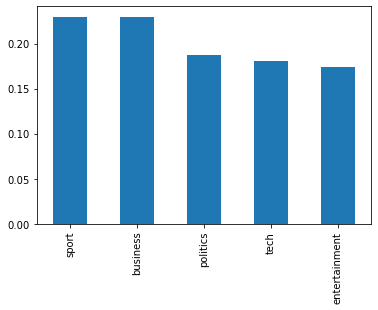

In [10]:
bbc = BbcDataset()
df = bbc.get_pandas_alike_dataset()
bbc.get_info(df)

In [11]:
bbc.preprocessing()

## LogisticRegression

In [27]:
X_train, X_val, X_test, y_train, y_val, y_test = bbc.get_data_for_sklearn()
len(X_train), len(X_val), len(X_test)

(1602, 445, 178)

In [28]:
uniq_labels = bbc.uniq_labels

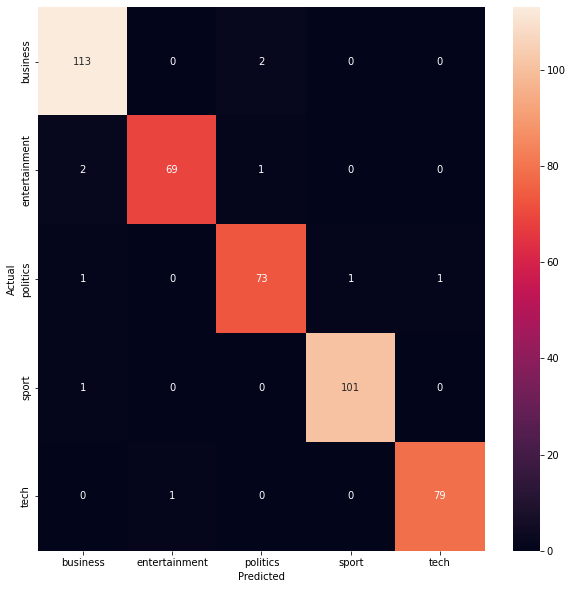

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

model = LogisticRegression()

model.fit(X_train, y_train)
y_pred = model.predict(X_val)


conf_mat = confusion_matrix(y_val, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',)
plt.ylabel('Actual')
plt.xlabel('Predicted')
ax.xaxis.set_ticklabels(uniq_labels)
ax.yaxis.set_ticklabels(uniq_labels)
plt.show()

In [30]:
from sklearn import metrics
print(metrics.classification_report(y_val, y_pred, target_names=uniq_labels))

               precision    recall  f1-score   support

     business       0.97      0.98      0.97       115
entertainment       0.99      0.96      0.97        72
     politics       0.96      0.96      0.96        76
        sport       0.99      0.99      0.99       102
         tech       0.99      0.99      0.99        80

     accuracy                           0.98       445
    macro avg       0.98      0.98      0.98       445
 weighted avg       0.98      0.98      0.98       445



In [31]:
print('Val accuracy: {}'.format(metrics.accuracy_score(y_val, y_pred)))

Val accuracy: 0.9775280898876404


In [32]:
y_pred = model.predict(X_test)
print('Test accuracy: {}'.format(metrics.accuracy_score(y_test, y_pred)))

Test accuracy: 0.9887640449438202


## DistilBert

In [39]:
from transformers import DistilBertForSequenceClassification
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=bbc.num_labels, id2label=bbc.id2label, label2id=bbc.label2id)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

loading configuration file config.json from cache at C:\Users\Professional/.cache\huggingface\hub\models--distilbert-base-uncased\snapshots\043235d6088ecd3dd5fb5ca3592b6913fd516027\config.json
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "business",
    "1": "entertainment",
    "2": "politics",
    "3": "sport",
    "4": "tech"
  },
  "initializer_range": 0.02,
  "label2id": {
    "business": 0,
    "entertainment": 1,
    "politics": 2,
    "sport": 3,
    "tech": 4
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.22.2",
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at C:\Users\

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
       

In [40]:
train_dataset, val_dataset, test_dataset = bbc.get_data_for_distilbert()

In [41]:
from transformers import TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    return {
        'Accuracy': acc,
        'F1': f1,
        'Precision': precision,
        'Recall': recall
    }

In [42]:
training_args = TrainingArguments(
    output_dir='./outputs/DistilBERT/',
    do_train=True,
    do_eval=True,
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=100,
    weight_decay=0.01,
    logging_strategy='steps',
    logging_dir='./outputs/multi-class-logs',
    logging_steps=50,
    evaluation_strategy="steps",
    eval_steps=50,
    load_best_model_at_end=True
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [43]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics= compute_metrics
)

In [44]:
trainer.train()

***** Running training *****
  Num examples = 1602
  Num Epochs = 5
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 505


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
50,1.355000,0.723160,0.957303,0.955872,0.956133,0.957196
100,0.293900,0.155137,0.961798,0.961825,0.961823,0.963717
150,0.112800,0.103255,0.970787,0.970201,0.971358,0.969386
200,0.100700,0.133989,0.970787,0.970685,0.969919,0.972063
250,0.049000,0.146166,0.973034,0.972987,0.971781,0.975047
300,0.032800,0.124252,0.975281,0.974988,0.973021,0.977341
350,0.003700,0.120582,0.975281,0.974832,0.974412,0.975542
400,0.025600,0.142561,0.968539,0.968048,0.965665,0.971085
450,0.002800,0.134462,0.970787,0.970319,0.968311,0.972824
500,0.011100,0.133838,0.970787,0.970319,0.968311,0.972824


***** Running Evaluation *****
  Num examples = 445
  Batch size = 16
***** Running Evaluation *****
  Num examples = 445
  Batch size = 16
***** Running Evaluation *****
  Num examples = 445
  Batch size = 16
***** Running Evaluation *****
  Num examples = 445
  Batch size = 16
***** Running Evaluation *****
  Num examples = 445
  Batch size = 16
***** Running Evaluation *****
  Num examples = 445
  Batch size = 16
***** Running Evaluation *****
  Num examples = 445
  Batch size = 16
***** Running Evaluation *****
  Num examples = 445
  Batch size = 16
***** Running Evaluation *****
  Num examples = 445
  Batch size = 16
***** Running Evaluation *****
  Num examples = 445
  Batch size = 16
Saving model checkpoint to ./outputs/DistilBERT/checkpoint-500
Configuration saved in ./outputs/DistilBERT/checkpoint-500\config.json
Model weights saved in ./outputs/DistilBERT/checkpoint-500\pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loa

TrainOutput(global_step=505, training_loss=0.1967844944447279, metrics={'train_runtime': 9865.9275, 'train_samples_per_second': 0.812, 'train_steps_per_second': 0.051, 'total_flos': 1061120630937600.0, 'train_loss': 0.1967844944447279, 'epoch': 5.0})

In [45]:
q = [trainer.evaluate(eval_dataset=data) for data in [train_dataset, val_dataset, test_dataset]]
pd.DataFrame(q, index=["train","val","test"]).iloc[:,:5]

***** Running Evaluation *****
  Num examples = 1602
  Batch size = 16


***** Running Evaluation *****
  Num examples = 445
  Batch size = 16
***** Running Evaluation *****
  Num examples = 178
  Batch size = 16


,eval_loss,eval_Accuracy,eval_F1,eval_Precision,eval_Recall
train,0.006070,0.999376,0.999372,0.999303,0.999443
val,0.133838,0.970787,0.970319,0.968311,0.972824
test,0.002655,1.000000,1.000000,1.000000,1.000000


In [49]:
model_path = "./outputs/DistilBERT"
trainer.save_model(model_path)
bbc.tokenizer.save_pretrained(model_path)

tokenizer config file saved in ./outputs/DistilBERT\tokenizer_config.json
Special tokens file saved in ./outputs/DistilBERT\special_tokens_map.json


('./outputs/DistilBERT\\tokenizer_config.json',
 './outputs/DistilBERT\\special_tokens_map.json',
 './outputs/DistilBERT\\vocab.txt',
 './outputs/DistilBERT\\added_tokens.json')

In [50]:
from transformers import pipeline, DistilBertForSequenceClassification, DistilBertTokenizer

model = DistilBertForSequenceClassification.from_pretrained(model_path)
tokenizer= DistilBertTokenizer.from_pretrained(model_path)
nlp= pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

loading configuration file ./outputs/DistilBERT\config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "business",
    "1": "entertainment",
    "2": "politics",
    "3": "sport",
    "4": "tech"
  },
  "initializer_range": 0.02,
  "label2id": {
    "business": 0,
    "entertainment": 1,
    "politics": 2,
    "sport": 3,
    "tech": 4
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "problem_type": "single_label_classification",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.22.2",
  "vocab_size": 30522
}

loading weights file ./outputs/DistilBERT\pytorch_model.bi

In [51]:
nlp("""
After winning 16 of their 19 games in the second half of last season to finish just one point behind champions Manchester City, Jurgen Klopp's side are now finding their gameplans going out of the window before half-time
""")

[{'label': 'sport', 'score': 0.9981555342674255}]

## Выводы
Обе модели отлично решают задачу классификации


 Model| Accuracy - test | Accuracy - val
--- | --- | ---
LogisticRegression | 0.99 | 0.98
DistilBert | 1 | 0.97